<a href="https://colab.research.google.com/github/ocrifydotnet/idcardimages/blob/main/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 32.1 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset

dataset = load_dataset("dinhquangson/donut-base-sroie")

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/dinhquangson___imagefolder/dinhquangson--donut-base-sroie-4d9f76aa2a10cc0e/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 70
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 6
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 1
    })
})

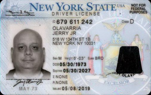

In [5]:
example = dataset['train'][0]
image = example['image']
# let's make the image a bit smaller when visualizing
width, height = image.size
display(image.resize((int(width*0.3), int(height*0.3))))

In [7]:
from PIL import Image
from io import BytesIO
import base64
from ast import literal_eval

def encode_pil_image(image: Image) -> str:
    buffer = BytesIO()
    image.save(buffer, format='JPEG')
    img_data = buffer.getvalue()
    return base64.b64encode(img_data).decode('utf-8')
encoded_img = encode_pil_image(image)

ground_truth = example['ground_truth']
data = literal_eval(ground_truth)['gt_parse']

In [8]:
from transformers import Pix2StructForConditionalGeneration, AutoProcessor

repo_id = "google/pix2struct-base"

processor = AutoProcessor.from_pretrained(repo_id)
model = Pix2StructForConditionalGeneration.from_pretrained(repo_id, is_encoder_decoder=True)

In [9]:
import json
import random
from typing import Any, List
from torch.utils.data import Dataset

added_tokens = []

class ImageCaptioningDataset(Dataset):
    def __init__(
        self,
        dataset_name_or_path: str,
        max_patches: int = 1024,
        max_length: int = 512,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.split = split
        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.max_patches = max_patches
        self.max_length = max_length
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.gt_token_sequences = []
        for ground_truth in self.dataset["ground_truth"]:
            ground_truth = json.loads(ground_truth)
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        # prepare inputs
        encoding = processor(images=item["image"], max_patches=self.max_patches, return_tensors="pt")
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # prepare targets
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ).input_ids

        labels = input_ids.squeeze().clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        encoding["labels"] = labels
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return encoding, target_sequence

In [21]:
train_dataset = ImageCaptioningDataset("dinhquangson/donut-base-sroie",
                                       split="train", sort_json_key=False) # cord dataset is preprocessed, so no need for this
val_dataset = ImageCaptioningDataset("dinhquangson/donut-base-sroie",
                                       split="validation", sort_json_key=False) # cord dataset is preprocessed, so no need for this

In [22]:
encoding, target_sequence = train_dataset[0]
print(encoding.keys())

dict_keys(['flattened_patches', 'attention_mask', 'labels'])


In [23]:
print(processor.decode([id.item() for id in encoding["labels"] if id != -100]))

<s_name><s_state> NEW YORK STATE</s_state><s_person> OLAVARRIA JERRY JR</s_person></s_name><s_date><s_dob> 05/30/1973</s_dob></s_date></s>


In [24]:
print(target_sequence)

<s_name><s_state>NEW YORK STATE</s_state><s_person>OLAVARRIA JERRY JR</s_person></s_name><s_date><s_dob>05/30/1973</s_dob></s_date>


In [25]:
print("Number of added tokens:", len(added_tokens))
print(added_tokens)

Number of added tokens: 64
['<s_menu>', '</s_menu>', '<s_nm>', '</s_nm>', '<s_cnt>', '</s_cnt>', '<s_price>', '</s_price>', '<s_sub_total>', '</s_sub_total>', '<s_subtotal_price>', '</s_subtotal_price>', '<s_service_price>', '</s_service_price>', '<s_tax_price>', '</s_tax_price>', '<s_etc>', '</s_etc>', '<s_total>', '</s_total>', '<s_total_price>', '</s_total_price>', '<s_sub>', '</s_sub>', '<s_cashprice>', '</s_cashprice>', '<s_changeprice>', '</s_changeprice>', '<s_menutype_cnt>', '</s_menutype_cnt>', '<s_menuqty_cnt>', '</s_menuqty_cnt>', '<s_discount_price>', '</s_discount_price>', '<s_unitprice>', '</s_unitprice>', '<s_total_etc>', '</s_total_etc>', '<s_creditcardprice>', '</s_creditcardprice>', '<s_num>', '</s_num>', '<s_discountprice>', '</s_discountprice>', '<s_emoneyprice>', '</s_emoneyprice>', '<s_void_menu>', '</s_void_menu>', '<s_othersvc_price>', '</s_othersvc_price>', '<s_vatyn>', '</s_vatyn>', '<s_itemsubtotal>', '</s_itemsubtotal>', '<s_name>', '</s_name>', '<s_state>',

In [26]:
len(processor.tokenizer)

50408

In [27]:
from torch.utils.data import DataLoader
import multiprocessing

num_cores = multiprocessing.cpu_count()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=num_cores)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=num_cores)

In [28]:
# get first batch
batch = next(iter(train_dataloader))
encoding, target_sequences = batch

In [29]:
for k,v in encoding.items():
  print(k,v.shape)

flattened_patches torch.Size([1, 1024, 770])
attention_mask torch.Size([1, 1024])
labels torch.Size([1, 512])


In [30]:
print(processor.batch_decode([id for id in encoding["labels"].squeeze().tolist() if id != -100]))

['<s_name>', '<s_state>', 'I', 'OW', 'A', '</s_state>', '<s_person>', 'S', 'VE', 'INS', 'SON', 'V', 'EST', 'EI', 'NN', '</s_person>', '</s_name>', '<s_date>', '<s_dob>', '', '1', '1', '/', '0', '3', '/', '1', '9', '8', '7', '</s_dob>', '</s_date>', '</s>']


In [31]:
from pathlib import Path
import re
from nltk import edit_distance
import numpy as np

import torch

from transformers.optimization import Adafactor, get_cosine_schedule_with_warmup

import pytorch_lightning as pl


class Pix2Struct(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        encoding, _ = batch

        outputs = self.model(**encoding)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        encoding, answers = batch
        flattened_patches, attention_mask = encoding["flattened_patches"], encoding["attention_mask"]
        batch_size = flattened_patches.shape[0]
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.text_config.decoder_start_token_id, device=self.device)

        outputs = self.model.generate(flattened_patches=flattened_patches,
                                      attention_mask=attention_mask,
                                      # decoder_input_ids=decoder_input_ids,
                                      max_new_tokens=512,
                                      return_dict_in_generate=True,)

        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            # seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = []
        for pred, answer in zip(predictions, answers):
            # pred = re.sub(r"(?:(?<=>) | (?=", "", answer, count=1)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        optimizer = Adafactor(self.parameters(), scale_parameter=False, relative_step=False, lr=self.config.get("lr"), weight_decay=1e-05)
        scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.config.get("num_warmup_steps"),
                                                    num_training_steps=self.config.get("max_steps"))

        return [optimizer], [scheduler]

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [32]:
config = {
          "num_warmup_steps": 1000,
          "max_steps": 30000,
          "lr": 0.01,
          "check_val_every_n_epoch": 5,
          "gradient_clip_val": 1.0,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "accumulate_grad_batches": 8,
          "verbose": True,
          }

pl_module = Pix2Struct(config, processor, model)

In [33]:

from pytorch_lightning.callbacks import Callback, EarlyStopping

In [34]:
trainer = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_steps=config.get("max_steps"),
    check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
    gradient_clip_val=config.get("gradient_clip_val"),
    accumulate_grad_batches=config.get("accumulate_grad_batches")
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
torch.set_grad_enabled(True)  # Context-manager

trainer.fit(pl_module)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | Pix2StructForConditionalGeneration | 282 M 
-------------------------------------------------------------
282 M     Trainable params
0         Non-trainable params
282 M     Total params
1,130.150 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]